In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from helpers import plot_bars, cross_validation
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('../data/processed_data/data_1.csv')

In [3]:
df.head()

,CRASH_DATETIME,CASUALTY,FRONT_OR_BACK_ENDED,GOING_STRAIGHT_AHEAD,IN_INTERSECTION,TRUCK_TAXI_BIKE,CLUSTER
0,07/01/2012 10:40,0,0,0,0,0,45
1,07/01/2012 12:18,0,0,0,0,1,25
2,07/01/2012 18:00,0,0,0,0,0,69
3,07/01/2012 19:30,0,0,0,0,0,69
4,07/01/2012 20:00,0,0,0,0,1,58


# Preprocessing

In [4]:
df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH_DATETIME'])

In [5]:
df['IS_NIGHT'] = df['CRASH_DATETIME'].dt.hour.isin([*range(8), *range(19, 25)]).astype(int)

### Make cluster into a binary variable

In [6]:
most_accidents = df.groupby('CLUSTER')['CASUALTY'].mean().loc[lambda x: x > df['CASUALTY'].mean()].index
arr = np.unique(df['CLUSTER'])
filtered = arr[~np.isin(arr, most_accidents)]
colors = pd.concat([pd.Series(0, index=filtered), pd.Series(1, index=most_accidents)])
df['CLUSTER'] = df['CLUSTER'].map(colors)

In [7]:
X = df.drop(columns=['CRASH_DATETIME', 'CASUALTY'])
y = df['CASUALTY']

In [15]:
def get_pipeline(model, **kwargs):
    pipe = Pipeline([
        ('o', SMOTE(sampling_strategy=0.3, random_state=2022)), 
        ('u', RandomUnderSampler(sampling_strategy=0.5, random_state=2022)), 
        ('m', model(**kwargs))
    ])
    return pipe

# Baseline Model

In [16]:
dummy_pipe = get_pipeline(DummyClassifier)
dummy = cross_val_score(dummy_pipe, X, y, scoring='f1', n_jobs=-1).mean()
print("5-Fold Cross Validation Average F1-score =", dummy)

5-Fold Cross Validation Average F1-score = 0.0


# Logistic Regression

In [17]:
log_pipe = get_pipeline(LogisticRegression)
log = cross_val_score(log_pipe, X, y, scoring='f1', n_jobs=-1).mean()
print("5-Fold Cross Validation Average F1-score =", log)

5-Fold Cross Validation Average F1-score = 0.237782339710429


# Random Forest

In [18]:
rf_pipe = get_pipeline(RandomForestClassifier)
rf = cross_val_score(rf_pipe, X, y, scoring='f1', n_jobs=-1).mean()
print("5-Fold Cross Validation Average F1-score =", rf)

5-Fold Cross Validation Average F1-score = 0.2583330730665293


# Decision Tree

In [19]:
tree_pipe = get_pipeline(DecisionTreeClassifier)
tree = cross_val_score(tree_pipe, X, y, scoring='f1', n_jobs=-1).mean()
print("5-Fold Cross Validation Average F1-score =", tree)

5-Fold Cross Validation Average F1-score = 0.25943150204792703


# Ensemble

In [20]:
models = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier(n_jobs=-1)),
    ('tree', DecisionTreeClassifier())
]

ensemble_pipe = get_pipeline(VotingClassifier, estimators=models)
ensemble = cross_val_score(ensemble_pipe, X, y, scoring='f1', n_jobs=-1).mean()
print("5-Fold Cross Validation Average F1-score =", ensemble)

5-Fold Cross Validation Average F1-score = 0.25943150204792703


# Plot the F1 scores

In [22]:
data_to_plot = pd.DataFrame({
    'model': ['Baseline', 'Logistic Regression', 'Random Forest', 'Decision Tree', 'Ensemble'],
    'Scores': [dummy, log, rf, tree, ensemble]}
).sort_values('Scores')

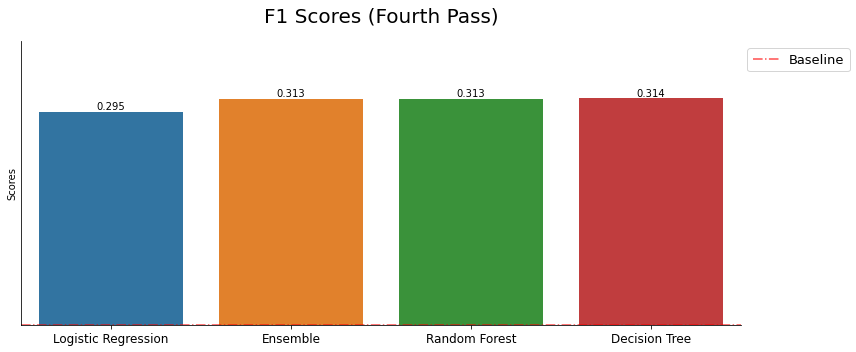

In [23]:
plot_bars(
    x='model', y='Scores', data=data_to_plot.query('model != "Baseline"'), 
    to_filename='fifth_pass', baseline=data_to_plot.loc[data_to_plot['model'] == "Baseline", 'Scores'].iat[-1], 
    title='F1 Scores (Fourth Pass)'
)